In [1]:
# Imports for this project
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils import data
from tqdm import tqdm

In [2]:
# Grab the MNIST dataset
training_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testing_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [2]:
# Verify that GPU is connected and available

print(torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'The system GPU | {torch.cuda.get_device_name(0) if not None else 'Error'} | is {'AVAILABLE' if torch.cuda.is_available() else 'NOT AVAILABLE' }')

2.6.0+cu124
The system GPU | NVIDIA GeForce RTX 4060 Laptop GPU | is AVAILABLE


In [4]:
class MNIST_Auto_Encoder(nn.Module):
    def __init__(self, bottleneck, hidden_layer_size=784):
        super().__init__()
        
        # Defined number of features for the image
        input_size=784

        # Encoder section
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_layer_size), # Input to hidden
            nn.ReLU(inplace=True),                                             # Activation Function
            nn.Linear(in_features=hidden_layer_size, out_features=bottleneck)  # Hidden to bottleneck
        )

        # Decoder Section
        self.decoder = nn.Sequential(
            nn.Linear(in_features=bottleneck, out_features=hidden_layer_size), # Bottleneck to hidden
            nn.ReLU(inplace=True),                                             # Activation Function
            nn.Linear(in_features=hidden_layer_size, out_features=input_size), # Hidden to output
            nn.Sigmoid(inplace=True)                                           # Force output pixels to be between 0 and 1
        )

    def forward(self, x) -> torch.Tensor:
        
        # Extract batch size and resize input into the nn
        batch_size = x.size(0)
        x_flattened = x.view(batch_size, -1)

        # Encode then decode the input
        x_encoded = self.encoder(x_flattened)
        x_decoded = self.decoder(x_encoded)

        # Reshape decoded x for final result
        x_predicted = x_decoded.view(batch_size, 1, 28, 28)
        
        return x_predicted
        

In [5]:
# Store the data for this test
k_over_training_loss = []
k_over_testing_loss = [] 


epoch_over_training_loss = []
epoch_over_testing_loss = []

'''
Data for the graph will be in the form of
{
    k: int
    final_training/testing_loss: float
}
'''

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [ ]:
# Model hyperparameters
epochs = 10
batch_size = 64
learning_rate = 0.1

# Question specific hyperparameters
hidden_layer_size = 1000
k_start = 748
k_end = 0
k_step = 160

# Loop through each bottlenecks
for k in range(k_start, k_end, k_step):
    
    print(f'########## With bottleneck = {k} ############')
    
    train_loader = data.DataLoader(training_set, 
                                    batch_size=batch_size, 
                                    shuffle=True,
                                    num_workers=5, 
                                    pin_memory=True
                               )
    
    test_loader = data.DataLoader(testing_set, 
                                    batch_size=batch_size, 
                                    shuffle=False,
                                    num_workers=5, 
                                    pin_memory=True
                               )

    model = MNIST_Auto_Encoder(k, hidden_layer_size=hidden_layer_size)
    model.to(device)

    total_params, trainable_params = count_parameters(model)

    print(f' ~~ Total/Trainable Parameters: {total_params}')

    loss_function = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Have references to variables outside of the epoch loop
    avg_training_loss = 0
    avg_testing_loss = 0

    print(model)

    # Epoch Loop
    for epoch in range(epochs):
        print(f'----- Epoch: {epoch + 1}/{epochs} -----')

        # Per epoch reset accumulated loss
        avg_training_loss = 0
        avg_testing_loss = 0

        # Run through each batch
        for images, _ in tqdm(train_loader, desc='Training', unit=' batch'):
            # Move data into the GPU
            images = images.to(device)

            # Zero out gradients
            optimizer.zero_grad()

            # Calc loss
            generated_images = model(images)
            loss = loss_function(generated_images, images)

            # Calc gradient and step
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                avg_training_loss += loss.item()

        # Set up for calculating testing loss
        avg_training_loss /=  len(train_loader)

        model.eval()

        # Calc training loss
        with torch.no_grad():
            for test_images, _ in tqdm(test_loader, desc='Testing', unit=' batch'):
                test_images = test_images.to(device)
                generated_test_images = model(test_images)
                
                avg_testing_loss += loss_function(generated_test_images, test_images).item()

        avg_testing_loss /=  len(test_loader)

        model.train()
        
        print("")

        print(f'   -> Training Loss: {avg_training_loss: .4f}\n')
        print(f'   -> Testing Loss: {avg_testing_loss: .4f}\n')

    # Add end results to the lists
    k_over_training_loss.append({
        "k": k,
        "training_loss": avg_training_loss 
    })

    k_over_testing_loss.append({
        "k": k,
        "testing_loss": avg_testing_loss
    })



        


In [ ]:
ks = [d["k"] for d in k_over_training_loss]
train_loss = [d["training_loss"] for d in k_over_training_loss]
test_loss = [d["testing_loss"] for d in k_over_testing_loss]

plt.figure(figsize=(8, 5))
plt.plot(ks, train_loss, label="Training Loss")
plt.plot(ks, test_loss, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MNIST AutoEncoder: Bottleneck vs. Training/Testing Loss")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
def freeze_module(m):
    for p in m.parameters():
        p.requires_grad = False

def unfreeze_module(m):
    for p in m.parameters():
        p.requires_grad = True

epoch_over_training_loss_per_model = []
epoch_over_testing_loss_per_model = []

'''
For of the data will be....

data = {
    epoch: int
    training/testing loss: float
    model_name: str
}
'''

'\nFor of the data will be....\n\ndata = {\n    epoch: int\n    training/testing loss: float\n    model_name: str\n}\n'

In [ ]:
optimal_k = 10 # PLACEHOLDER

# Have reference
src_model = model

# 1. Untrained encoder not frozen
encoder_clean_unfrozen = MNIST_Auto_Encoder(optimal_k, hidden_layer_size=hidden_layer_size).to(device).encoder

# 2. Untrained encoder but frozen
encoder_clean_frozen = MNIST_Auto_Encoder(optimal_k, hidden_layer_size=hidden_layer_size).to(device).encoder
freeze_module(encoder_clean_frozen)
unfreeze_module(encoder_clean_frozen[-1])

# 3. Trained encoder not frozen
encoder_trained_unfrozen = MNIST_Auto_Encoder(optimal_k, hidden_layer_size=hidden_layer_size).to(device).encoder
encoder_trained_unfrozen.load_state_dict(src_model.encoder.state_dict())

# 4. Trained encoder but frozen
encoder_trained_frozen = MNIST_Auto_Encoder(optimal_k, hidden_layer_size=hidden_layer_size).to(device).encoder
encoder_trained_frozen.load_state_dict(src_model.encoder.state_dict())

freeze_module(encoder_trained_frozen)
unfreeze_module(encoder_trained_frozen[-1])

models = [encoder_clean_unfrozen, encoder_clean_unfrozen, encoder_trained_unfrozen, encoder_trained_frozen]



NameError: name 'model' is not defined

In [ ]:
# Model hyperparameters
epochs = 10
batch_size = 64
learning_rate = 0.1

print(f'######## Begin Training Encoders on bottleneck={optimal_k} ########')


train_loader = data.DataLoader(training_set, 
                                batch_size=batch_size, 
                                shuffle=True,
                                num_workers=5, 
                                pin_memory=True
                            )

test_loader = data.DataLoader(testing_set, 
                                batch_size=batch_size, 
                                shuffle=False,
                                num_workers=5, 
                                pin_memory=True
                            )

for sample_model, model_name in zip(models, ['Unfrozen Clean Encoder', 'Frozen Clean Encoder', 'Unfrozen Pretrained Encoder', 'Frozen Pretrained Encoder']):

    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(sample_model.parameters(), lr=learning_rate)

    avg_training_loss = 0
    avg_testing_loss = 0

    for epoch in range(epochs):
        print(f'----- Epoch: {epoch + 1}/{epochs} -----')

        # Per epoch reset accumulated loss
        avg_training_loss = 0
        avg_testing_loss = 0

        # Run through each batch
        for images, labels in tqdm(train_loader, desc='Training', unit=' batch'):
            # Move data into the GPU
            images = images.to(device)

            # Zero out gradients
            optimizer.zero_grad()

            # Calc loss
            logits = sample_model(images)
            loss = loss_function(logits, labels)

            # Calc gradient and step
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                avg_training_loss += loss.item()

        # Set up for calculating testing loss
        avg_training_loss /=  len(train_loader)

        sample_model.eval()

        # Calc training loss
        with torch.no_grad():
            for test_images, labels in tqdm(test_loader, desc='Testing', unit=' batch'):
                test_images = test_images.to(device)
                logits = sample_model(test_images)
                
                avg_testing_loss += loss_function(logits, labels).item()

        avg_testing_loss /=  len(test_loader)

        sample_model.train()
        
        print("")

        print(f'   -> Training Loss: {avg_training_loss: .4f}\n')
        print(f'   -> Testing Loss: {avg_testing_loss: .4f}\n')

        # Add end results to the lists
        epoch_over_training_loss_per_model.append({
            "epoch": epoch,
            "training_loss": avg_training_loss,
            "model_name": model_name
        })

        epoch_over_testing_loss_per_model.append({
            "epoch": epoch,
            "training_loss": avg_training_loss,
            "model_name": model_name
        })

## Transfer Learning

### Problem 3: Build and train a network for classifying CIFAR, with at least 5 layers, and at least one of them being a CNN layer. Your goal should be good performance, so keep track of the testing loss as you do

In [3]:
tfm = transforms.Compose([
    transforms.ToTensor(),
])

trainset_full_CIFAR10 = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
testset_full_CIFAR10  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=tfm)

In [4]:
class CIFAR10_Classifier(nn.Module):
    def __init__(self, C_dropout, F_dropout):
        super().__init__()

        conv2d_dropout = C_dropout

        conv_layer_1 = 30
        conv_layer_2 = 64
        
        conv_layer_3 = 128
        conv_layer_4 = 256

        self.forward_funnel_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=conv_layer_1, kernel_size=5),   # Extract useful features from the beginning
            nn.ReLU(inplace=True),
            nn.Dropout2d(conv2d_dropout),

            nn.Conv2d(in_channels=conv_layer_1, out_channels=conv_layer_2, kernel_size=3),  # Extract useful features from the learned features
            nn.ReLU(inplace=True),
            nn.Dropout2d(conv2d_dropout),
            nn.MaxPool2d(kernel_size=2, stride=2),                       # Reduce dimensionality
        )

        self.forward_funnel_2 = nn.Sequential(
            nn.Conv2d(in_channels=conv_layer_2, out_channels=conv_layer_3, kernel_size=3),   # Extract useful features from the beginning
            nn.ReLU(inplace=True),
            nn.Dropout2d(conv2d_dropout),

            nn.Conv2d(in_channels=conv_layer_3, out_channels=conv_layer_4, kernel_size=3),  # Extract useful features from the learned features
            nn.ReLU(inplace=True),
            nn.Dropout2d(conv2d_dropout),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Compute the number of features after the input has passed the funnel
        with torch.no_grad():
            test_input = torch.zeros(1, 3, 32, 32)

            test_input.to(device)

            features = self.forward_funnel_1(test_input)
            features = self.forward_funnel_2(features)

            total_count = features.view(1, -1).size(1)

        full_node_dropout = F_dropout
        self.output_nodes = 100

        self.classifer = nn.Sequential(
            nn.Flatten(),                                           # Flatten the image from the funnel
            nn.Linear(in_features=total_count, out_features=1000), 
            nn.ReLU(inplace=True),
            nn.Dropout(full_node_dropout),

            nn.Linear(in_features=1000, out_features=500),
            nn.ReLU(inplace=True),
            nn.Dropout(full_node_dropout),

            nn.Linear(in_features=500, out_features=250),
            nn.ReLU(inplace=True),
            nn.Dropout(full_node_dropout),

            nn.Linear(in_features=250, out_features=self.output_nodes),
            nn.ReLU(inplace=True),
            nn.Dropout(full_node_dropout),
        )

        self.output_layer = nn.Linear(in_features=self.output_nodes, out_features=10)
    
    def partial_forward(self, x):
        x = self.forward_funnel_1(x)
        x = self.forward_funnel_2(x)
        x = self.classifer(x)

        return x

    def forward(self, x):
        x = self.partial_forward(x)
        logits = self.output_layer(x)

        return logits


In [118]:
epoch_over_training_loss_CIFAR10 = []
epoch_over_testing_loss_CIFAR10 = []

'''
Form of the data

data = 
{
    epoch: int
    training/testing loss: float
}
'''

'\nForm of the data\n\ndata = \n{\n    epoch: int\n    training/testing loss: float\n}\n'

In [119]:
# Hyperparameter setup
epochs = 15
batch_size = 64
learning_rate = 5e-4
decay_rate = 4e-4

c_dropout = 0.25
f_dropout = 0.25

print('######## Begining training for CIFAR10 classifier ##########')

# Setup data loaders
trainset_loader_CIFAR10 = data.DataLoader(trainset_full_CIFAR10,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   # num_workers=5,
                                   pin_memory=True)

testset_loader_CIFAR10 = data.DataLoader(testset_full_CIFAR10,
                                   batch_size=batch_size,
                                   # num_workers=5,
                                   shuffle=False,
                                   pin_memory=True)

model = CIFAR10_Classifier(c_dropout, f_dropout)
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), 
                       lr=learning_rate, 
                       weight_decay=decay_rate
                       )

# Have references to variables outside of the epoch loop
avg_training_loss = 0
avg_testing_loss = 0

# Epoch Loop
for epoch in range(epochs):
    print(f'----- Epoch: {epoch + 1}/{epochs} -----')
    
    avg_training_loss = 0
    avg_testing_loss = 0

    model.train()

    for x, Y in tqdm(trainset_loader_CIFAR10, desc='Training', unit=' batch'):
        # Transfer images to GPU
        x = x.to(device)
        Y = Y.to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # Send images to model
        x_pred = model(x)

        # Calc loss
        loss = loss_function(x_pred, Y)

        # Calc gradient and update weights
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            avg_training_loss += loss.item()

    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        for x, Y in tqdm(testset_loader_CIFAR10, desc='Testing', unit=' batches'):
            # Move the images to the GPU
            x = x.to(device)
            Y = Y.to(device)

            # Get logits and sum up total loss
            x_pred = model(x)
            avg_testing_loss += loss_function(x_pred, Y).item()

    # Get training loss
    avg_training_loss /= len(trainset_loader_CIFAR10)

     # Get testing loss
    avg_testing_loss /= len(testset_loader_CIFAR10)

    # Switch model back to training mode
    model.train()

    epoch_over_training_loss_CIFAR10.append({
        "epoch": epoch,
        "training_loss": avg_training_loss
        })
    
    epoch_over_testing_loss_CIFAR10.append({
        "epoch": epoch,
        "testing_loss": avg_testing_loss
        })
    

    print("")

    print(f'   -> Training Loss: {avg_training_loss: .4f}\n')
    print(f'   -> Testing Loss: {avg_testing_loss: .4f}\n')


######## Begining training for CIFAR10 classifier ##########
----- Epoch: 1/15 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 113.78 batches/s]



   -> Training Loss:  1.9835

   -> Testing Loss:  1.6358

----- Epoch: 2/15 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 121.53 batches/s]



   -> Training Loss:  1.6406

   -> Testing Loss:  1.4000

----- Epoch: 3/15 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 121.37 batches/s]



   -> Training Loss:  1.4772

   -> Testing Loss:  1.2939

----- Epoch: 4/15 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 114.75 batches/s]



   -> Training Loss:  1.3731

   -> Testing Loss:  1.2180

----- Epoch: 5/15 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 122.03 batches/s]



   -> Training Loss:  1.2839

   -> Testing Loss:  1.1045

----- Epoch: 6/15 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 119.01 batches/s]



   -> Training Loss:  1.2103

   -> Testing Loss:  1.0442

----- Epoch: 7/15 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 120.31 batches/s]



   -> Training Loss:  1.1515

   -> Testing Loss:  1.0042

----- Epoch: 8/15 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 120.32 batches/s]



   -> Training Loss:  1.0890

   -> Testing Loss:  0.9703

----- Epoch: 9/15 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 122.87 batches/s]



   -> Training Loss:  1.0346

   -> Testing Loss:  0.9094

----- Epoch: 10/15 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 119.10 batches/s]



   -> Training Loss:  0.9870

   -> Testing Loss:  0.8829

----- Epoch: 11/15 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 117.74 batches/s]



   -> Training Loss:  0.9384

   -> Testing Loss:  0.8758

----- Epoch: 12/15 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 113.31 batches/s]



   -> Training Loss:  0.9021

   -> Testing Loss:  0.8511

----- Epoch: 13/15 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 113.70 batches/s]



   -> Training Loss:  0.8649

   -> Testing Loss:  0.8256

----- Epoch: 14/15 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 122.93 batches/s]



   -> Training Loss:  0.8303

   -> Testing Loss:  0.8115

----- Epoch: 15/15 -----


Testing: 100%|██████████| 157/157 [00:01<00:00, 122.39 batches/s]


   -> Training Loss:  0.7996

   -> Testing Loss:  0.8072



Final Accuracy: 0.7297


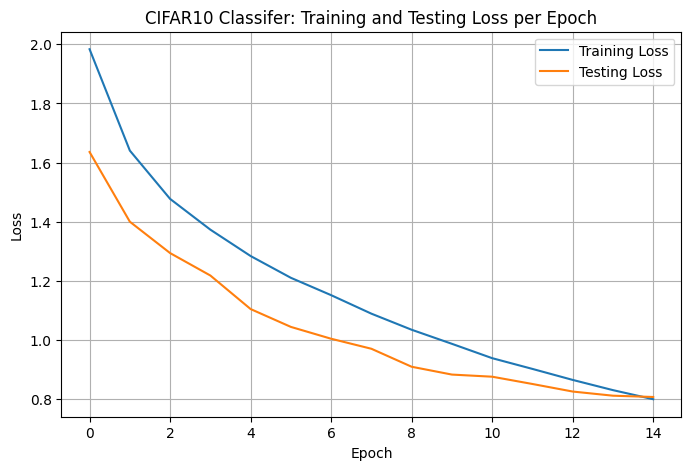

In [120]:
model.eval()

correct = total = 0

with torch.no_grad():
    for xb, yb in testset_loader_CIFAR10:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total += yb.numel()

final_accuracy = float(correct / total)

print(f"Final Accuracy: {final_accuracy}")

epochs = [d["epoch"] for d in epoch_over_training_loss_CIFAR10]
train_loss = [d["training_loss"] for d in epoch_over_training_loss_CIFAR10]
test_loss = [d["testing_loss"] for d in epoch_over_testing_loss_CIFAR10]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, test_loss, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CIFAR10 Classifer: Training and Testing Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

#### Results 

Testing Accuracy: 72.97%

Training Loss: 0.7996

Testing Loss: 0.8072

#### Final Model Hyperparameters

batch_size = 64

learning_rate = 5e-4

decay_rate = 4e-4

c_dropout = 0.25

f_dropout = 0.25


#### Model Architecture 1

In the beginning, I decided that I wanted to have two convolutional layers, one that extracted a lot of features from the image data and one that found more advanced features. Since the first layer would find as many initial features to start, I decided to make the out channel 128 and kernel size 5x5. Then, the second layer would condense those features, so I chose an out channel size of 64 and kernel size of 3x3. Additionally, I stacked 4 decreasing, funneling, fully-connected layers, 1000 -> 1000 -> 500 -> 100, that finally connected to the output layer. My reasoning was that doing this would allow me to find complex features that would become more and more concentrated and meaningful. Finally, I added a max pooling layer after the convolutional layers to help reduce dimensionality of the data and dropout layers after every layer to prevent overfitting. 

#### Optimizer
I went with Adam since I wanted to experiment with using different options. Furthermore, I wanted my loss to be as low as possible, so I wanted to use weight decay. As such, the final optimizer I used was AdamW since it handles weight decay better.

#### Initial training

I started with initial hyperparamters of batch_size = 64, learning_rate = 1e-3, decay_rate = 5e-4 (weight decay), c_dropout = 0.40 (the dropout probability for each convolutional layer), and f_dropout = 0.60 (the dropout probability for each fully-connected layer). After the first training, I noticed that my losses were not really good for this data set, training loss ~= 1.3 and testing loss ~= 1.25. Specially, they could never get past the 1.2 barrier and started to stagnate at the 14th epoch. Since I did not think overfitting was an issue yet, I decided to tweak the learning rate from 1e-3 to 5e-4.

In the second trial, I noticed that the issue of the model not being able to learn was still present, losses similar to the first trial, so I thought the maybe my dropout p's were a bit too high. This caused me to set both of them to 0.4.

In my next training attempt, I saw I was able to break past the 1.2 loss barrier by the 10th epoch which solidified my reasoning that my p's were too high, but I was unable to get a testing loss lower than ~1.10 after the 15th epoch. However, I did notice that model was still learning well, it was able to get training loss lower than 1.10, so I decided that I should try changing the weight decay to 4e-4 to see if it would help. I did not increase the weight decay since I thought that would cause my losses to be greater since I was already using a good amount of dropout.

For the fourth trial, I saw that I got similar testing loss, ~1.08, so I decided to try changing the other hyperparameters. Yet, no matter which ones I tried to change, I was unable to break the testing loss = 1.00 barrier, even though the model was learning well beyond that point. This led me to think that my architecture was a bit too complex, so I decided to rethink of what I was doing and change my model.

#### Model Architecture 2

For this iteration of the model, I decided to change the number of channels in my convolutional layers from 128 -> 64 to 30 -> 64. This happened because I decided to look at the image size which is 32x32 and realized that I might be trying to find too many features in the beginning but then sampling them down too much in the second layer. Instead, it would probably be better to find fewer initial features and then find complex relationships between them in the second convolutional layer. The second major change I made was making the fully-connected layers continously decreasing from 1000 -> 1000 -> 500 -> 100 to 1000 -> 500 -> 250 -> 100 since I wanted to downscale the model.

#### Training for Second Model

I decided to keep the hyperparameters that I obtained from the initial model since I thought they might work well with this new model, batch_size = 64, learning_rate = 5e-4, and decay_rate = 4e-4. However, I chose to decrease the dropouts both to 0.25 since I wanted to start at a new, lower point and tweak the dropout as I trained this new model.

For the first training attempt, my model performed way better than the first model both in terms of speed and accuracy since it was able to get training loss ~= 0.9 and testing loss ~= 0.89 at the 5th epoch. Beyond that point though, the model started overfitting severally and could not get past the testing loss being ~0.89. From this point owards, I tried tweaking the other hyperparameters but no matter what I changed and how I changed it. I could never get a testing loss beyond 0.9. This lead me to the conclusion that my model needed to be changed once again.

#### Model Architecture 3

For this model, I decided to add more convolutional layers plus an additional max pooling layer since the features that they can extract would be more useful compared to just plain fully-connected layers. As such, this model mirrors the second model but the initial convolution layers were changed from 30 -> 64 to 30 -> 64 -> 128 -> 256. I chose to make the channels increase since I thought that it would be better to learn more and more complex combinations of the initial features rather than trying to funnel them down. However, the pooling layer would help with funneling the features anyways, so it would be better to not do that inside of the convolutional layers themselves. These new layers also have kernel size 3x3.

#### Training for Third Model

With the optimal hyperparameters from the second model, batch_size = 64, learning_rate = 5e-4, decay_rate = 4e-4, c_dropout = 0.25, and f_dropout = 0.25, I was able to finally break the loss barrier and achieve a testing loss ~= 0.80 at the 15th epoch. Sadly, tuning the hyperparameters did not result in any new finds which makes me think that to get better accuracy, I would need to append more and more convolutional layers.

### Problem 4: Using a model of the same architecture (except for the last layer), train a model to detect whether a CIFAR image is upright, or has been rotated 90 degrees. (Note: You will need to modify the CIFAR data to construct the data you need for this task. How can you easily do this kind of rotation, with the image as a tensor?) Again, you want good performance, so make sure to track the testing loss as well (as defined by this new classification task).

In [5]:
class CIFAR10_Transformed_Classifier(CIFAR10_Classifier):
    def __init__(self, C_dropout, F_dropout):
        super().__init__(C_dropout, F_dropout)
        
        self.output_layer = nn.Linear(in_features=self.output_nodes, out_features=2)


    def forward(self, x):
        x = self.partial_forward(x)
        logits = self.output_layer(x)

        return logits


In [34]:
epoch_over_training_loss_CIFAR10_R = []
epoch_over_testing_loss_CIFAR10_R = []

In [35]:
# Hyperparameter setup
epochs = 50
batch_size = 50
learning_rate = 5e-4
decay_rate = 1e-3

c_dropout = 0.30
f_dropout = 0.30


print('######## Begining training for CIFAR10 classifier on rotated images ##########')

# Setup data loaders
trainset_loader_CIFAR10_R = data.DataLoader(trainset_full_CIFAR10,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   # num_workers=5,
                                   pin_memory=True)

testset_loader_CIFAR10_R = data.DataLoader(testset_full_CIFAR10,
                                   batch_size=batch_size,
                                   # num_workers=5,
                                   shuffle=False,
                                   pin_memory=True)

model = CIFAR10_Transformed_Classifier(c_dropout, f_dropout)
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), 
                       lr=learning_rate, 
                       weight_decay=decay_rate
                       )

# Have references to variables outside of the epoch loop
avg_training_loss = 0
avg_testing_loss = 0

# Epoch Loop
for epoch in range(epochs):
    print(f'----- Epoch: {epoch + 1}/{epochs} -----')
    
    avg_training_loss = 0
    avg_testing_loss = 0

    model.train()

    for x, _ in tqdm(trainset_loader_CIFAR10_R, desc='Training', unit=' batch'):

        labels_upright = torch.zeros(x.size(0), dtype=torch.long)

        images_rotated = torch.rot90(x, 1, [2, 3])
        labels_rotated = torch.ones(x.size(0), dtype=torch.long)

        all_images = torch.cat([x, images_rotated])
        all_labels = torch.cat([labels_upright, labels_rotated])
        
        
        # Transfer images to GPU
        all_images = all_images.to(device)
        all_labels = all_labels.to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # Send images to model
        x_pred = model(all_images)

        # Calc loss
        loss = loss_function(x_pred, all_labels)

        # Calc gradient and update weights
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            avg_training_loss += loss.item()

    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        for x, _ in tqdm(testset_loader_CIFAR10_R, desc='Testing', unit=' batches'):
            
            labels_upright = torch.zeros(x.size(0), dtype=torch.long)

            images_rotated = torch.rot90(x, 1, [2, 3])
            labels_rotated = torch.ones(x.size(0), dtype=torch.long)

            all_images = torch.cat([x, images_rotated])
            all_labels = torch.cat([labels_upright, labels_rotated])
            
            # Transfer images to GPU
            all_images = all_images.to(device)
            all_labels = all_labels.to(device)
            
            # Move the images to the GPU
            all_images = all_images.to(device)
            all_labels = all_labels.to(device)

            # Get logits and sum up total loss
            x_pred = model(all_images)
            avg_testing_loss += loss_function(x_pred, all_labels).item()

    # Get training loss
    avg_training_loss /= len(trainset_loader_CIFAR10_R)

     # Get testing loss
    avg_testing_loss /= len(testset_loader_CIFAR10_R)

    # Switch model back to training mode
    model.train()

    epoch_over_training_loss_CIFAR10_R.append({
        "epoch": epoch,
        "training_loss": avg_training_loss
        })
    
    epoch_over_testing_loss_CIFAR10_R.append({
        "epoch": epoch,
        "testing_loss": avg_testing_loss
        })
    

    print("")

    print(f'   -> Training Loss: {avg_training_loss: .4f}\n')
    print(f'   -> Testing Loss: {avg_testing_loss: .4f}\n')


######## Begining training for CIFAR10 classifier on rotated images ##########
----- Epoch: 1/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 101.32 batches/s]



   -> Training Loss:  0.5809

   -> Testing Loss:  0.4976

----- Epoch: 2/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 102.16 batches/s]



   -> Training Loss:  0.5171

   -> Testing Loss:  0.4958

----- Epoch: 3/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 100.74 batches/s]



   -> Training Loss:  0.4993

   -> Testing Loss:  0.4724

----- Epoch: 4/50 -----


Testing: 100%|██████████| 200/200 [00:02<00:00, 99.13 batches/s] 



   -> Training Loss:  0.4852

   -> Testing Loss:  0.4594

----- Epoch: 5/50 -----


Testing: 100%|██████████| 200/200 [00:02<00:00, 97.73 batches/s] 



   -> Training Loss:  0.4758

   -> Testing Loss:  0.4368

----- Epoch: 6/50 -----


Testing: 100%|██████████| 200/200 [00:02<00:00, 97.79 batches/s]



   -> Training Loss:  0.4653

   -> Testing Loss:  0.4454

----- Epoch: 7/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 102.15 batches/s]



   -> Training Loss:  0.4538

   -> Testing Loss:  0.4215

----- Epoch: 8/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 100.99 batches/s]



   -> Training Loss:  0.4476

   -> Testing Loss:  0.4177

----- Epoch: 9/50 -----


Testing: 100%|██████████| 200/200 [00:02<00:00, 98.34 batches/s]



   -> Training Loss:  0.4396

   -> Testing Loss:  0.4169

----- Epoch: 10/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 101.62 batches/s]



   -> Training Loss:  0.4340

   -> Testing Loss:  0.3938

----- Epoch: 11/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 102.01 batches/s]



   -> Training Loss:  0.4234

   -> Testing Loss:  0.3838

----- Epoch: 12/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 101.68 batches/s]



   -> Training Loss:  0.4192

   -> Testing Loss:  0.3789

----- Epoch: 13/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 104.32 batches/s]



   -> Training Loss:  0.4138

   -> Testing Loss:  0.3749

----- Epoch: 14/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 103.10 batches/s]



   -> Training Loss:  0.4056

   -> Testing Loss:  0.3715

----- Epoch: 15/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 105.10 batches/s]



   -> Training Loss:  0.4018

   -> Testing Loss:  0.3621

----- Epoch: 16/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 102.36 batches/s]



   -> Training Loss:  0.3964

   -> Testing Loss:  0.3675

----- Epoch: 17/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 102.51 batches/s]



   -> Training Loss:  0.3893

   -> Testing Loss:  0.3540

----- Epoch: 18/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 104.77 batches/s]



   -> Training Loss:  0.3880

   -> Testing Loss:  0.3466

----- Epoch: 19/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 103.89 batches/s]



   -> Training Loss:  0.3829

   -> Testing Loss:  0.3432

----- Epoch: 20/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 102.60 batches/s]



   -> Training Loss:  0.3771

   -> Testing Loss:  0.3434

----- Epoch: 21/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 103.08 batches/s]



   -> Training Loss:  0.3753

   -> Testing Loss:  0.3468

----- Epoch: 22/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 102.01 batches/s]



   -> Training Loss:  0.3695

   -> Testing Loss:  0.3312

----- Epoch: 23/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 102.81 batches/s]



   -> Training Loss:  0.3661

   -> Testing Loss:  0.3328

----- Epoch: 24/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 102.89 batches/s]



   -> Training Loss:  0.3628

   -> Testing Loss:  0.3336

----- Epoch: 25/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 103.64 batches/s]



   -> Training Loss:  0.3584

   -> Testing Loss:  0.3230

----- Epoch: 26/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 103.35 batches/s]



   -> Training Loss:  0.3538

   -> Testing Loss:  0.3228

----- Epoch: 27/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 102.39 batches/s]



   -> Training Loss:  0.3520

   -> Testing Loss:  0.3310

----- Epoch: 28/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 102.24 batches/s]



   -> Training Loss:  0.3462

   -> Testing Loss:  0.3166

----- Epoch: 29/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 103.72 batches/s]



   -> Training Loss:  0.3460

   -> Testing Loss:  0.3191

----- Epoch: 30/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 103.58 batches/s]



   -> Training Loss:  0.3446

   -> Testing Loss:  0.3106

----- Epoch: 31/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 102.01 batches/s]



   -> Training Loss:  0.3380

   -> Testing Loss:  0.3262

----- Epoch: 32/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 102.92 batches/s]



   -> Training Loss:  0.3361

   -> Testing Loss:  0.3198

----- Epoch: 33/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 104.04 batches/s]



   -> Training Loss:  0.3320

   -> Testing Loss:  0.3125

----- Epoch: 34/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 103.11 batches/s]



   -> Training Loss:  0.3284

   -> Testing Loss:  0.3111

----- Epoch: 35/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 102.32 batches/s]



   -> Training Loss:  0.3271

   -> Testing Loss:  0.3031

----- Epoch: 36/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 101.85 batches/s]



   -> Training Loss:  0.3240

   -> Testing Loss:  0.3063

----- Epoch: 37/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 103.00 batches/s]



   -> Training Loss:  0.3199

   -> Testing Loss:  0.2987

----- Epoch: 38/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 105.12 batches/s]



   -> Training Loss:  0.3179

   -> Testing Loss:  0.3036

----- Epoch: 39/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 102.76 batches/s]



   -> Training Loss:  0.3114

   -> Testing Loss:  0.3009

----- Epoch: 40/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 102.75 batches/s]



   -> Training Loss:  0.3109

   -> Testing Loss:  0.3065

----- Epoch: 41/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 100.18 batches/s]



   -> Training Loss:  0.3078

   -> Testing Loss:  0.3071

----- Epoch: 42/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 100.18 batches/s]



   -> Training Loss:  0.3045

   -> Testing Loss:  0.3010

----- Epoch: 43/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 100.79 batches/s]



   -> Training Loss:  0.3013

   -> Testing Loss:  0.2990

----- Epoch: 44/50 -----


Testing: 100%|██████████| 200/200 [00:02<00:00, 99.57 batches/s] 



   -> Training Loss:  0.2970

   -> Testing Loss:  0.2971

----- Epoch: 45/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 100.86 batches/s]



   -> Training Loss:  0.2964

   -> Testing Loss:  0.2951

----- Epoch: 46/50 -----


Testing: 100%|██████████| 200/200 [00:02<00:00, 99.89 batches/s] 



   -> Training Loss:  0.2923

   -> Testing Loss:  0.2976

----- Epoch: 47/50 -----


Testing: 100%|██████████| 200/200 [00:02<00:00, 99.01 batches/s] 



   -> Training Loss:  0.2897

   -> Testing Loss:  0.2957

----- Epoch: 48/50 -----


Testing: 100%|██████████| 200/200 [00:02<00:00, 93.60 batches/s]



   -> Training Loss:  0.2857

   -> Testing Loss:  0.2943

----- Epoch: 49/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 100.68 batches/s]



   -> Training Loss:  0.2846

   -> Testing Loss:  0.2923

----- Epoch: 50/50 -----


Testing: 100%|██████████| 200/200 [00:01<00:00, 100.33 batches/s]


   -> Training Loss:  0.2808

   -> Testing Loss:  0.2898



In [36]:
# Save the model weights from problem 5
torch.save(model.state_dict(), 'Q4_model_weights.pth')

Final Accuracy: 0.87015


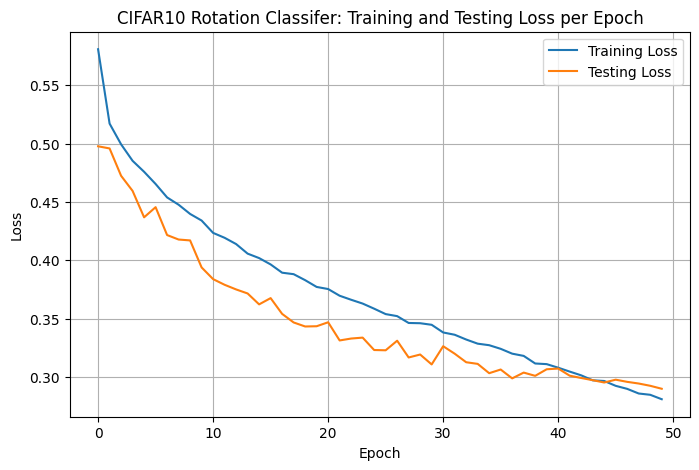

In [37]:
model.eval()
correct = total = 0
with torch.no_grad():
    for x, _ in testset_loader_CIFAR10_R:
        
        labels_upright = torch.zeros(x.size(0), dtype=torch.long)

        images_rotated = torch.rot90(x, 1, [2, 3])
        labels_rotated = torch.ones(x.size(0), dtype=torch.long)

        all_images = torch.cat([x, images_rotated])
        all_labels = torch.cat([labels_upright, labels_rotated])
        
        # Transfer images to GPU
        all_images = all_images.to(device)
        all_labels = all_labels.to(device)
        
        # Move the images to the GPU
        all_images = all_images.to(device)
        all_labels = all_labels.to(device)

        # Get logits and sum up total loss
        logits = model(all_images)
        
        pred = logits.argmax(1)
        
        correct += (pred == all_labels).sum().item()
        total += all_labels.numel()

final_accuracy = float(correct / total)

print(f"Final Accuracy: {final_accuracy}")


epochs = [d["epoch"] for d in epoch_over_training_loss_CIFAR10_R]
train_loss = [d["training_loss"] for d in epoch_over_training_loss_CIFAR10_R]
test_loss = [d["testing_loss"] for d in epoch_over_testing_loss_CIFAR10_R]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, test_loss, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CIFAR10 Rotation Classifer: Training and Testing Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

#### Results

Testing Accuracy: 87.015%

Training Loss: 0.2808

Testing Loss: 0.2898

#### Final Model Hyperparameters

epochs = 50

batch_size = 50

learning_rate = 5e-4

decay_rate = 1e-3

c_dropout = 0.30

f_dropout = 0.30

#### Model Architecture

For this problem, I am forced to maintain the original architecture for the best model that I found in Question 3. Of course, the final output layer is of size two for the two different classes to predict.

#### Initial Model Training

To start, I wanted to use different initial hyperparameters rather than the ones that I found for my model in Question 3 since I belived that doing so might allow me to learn more about my current model. As such, I used batch_size = 100, learning_rate = 1e-4, decay_rate = 5e-4, c_dropout = 0.10, and f_dropout = 0.10. For the first training loop, the model was able to achieve a training and testing loss of around 0.32 at the 11th epoch before it began to overfit. Unlike the previous models, the training and testing loss were pretty close to each other per epoch with not considerable gap, for the other models, the gap between the training and testing loss would be around 0.15 with the testing loss always being lower. Seeing this, I decided to go straight to tunning the dropout, from c_dropout = f_dropout = 0.10 to c_dropout = f_dropout = 0.20.

In the second trial, my model was only able to get a testing loss around 0.3180 at the 19th epoch before it began overfitting. Though, by the 4th epoch (around 0.40 loss), the model began learning way too slowly. At first, I wanted to change the dropout rate, but I wanted to fiddle around with the batch size a little bit more, so I decided to change the batch size from 100 to 125 first. Yet, this did not help as the model still was stuck at a similar loss. Decreasing the batch size to 50 gave me the same results, so I decided to move onto changing the learning rate.

For the fifth trial, I increased the learning rate from 1e-4 to 5e-4, and the model was able to get a testing loss = 0.3073 at the 17th epoch. By this point, I have started to notice that getting the loss lower than 0.25 would probably require better architecture. Seeing the results, I was satisfied with the learning rate, so I decided to once again change the dropouts since learning rate does not seem to be the reason as to why the model is learning slower.

In the sixth attempt, I changed the dropouts to be both 0.30 which let the model achieve a new minimum testing loss of 0.2960 at the 46th epoch. As can be seen, it seems the model requires a lot more training time at its current state. While it is training though, the training and testing losses decrement very slowly often with a minimal loss gap.

For my final change to training, I decided that I should try increasing the weight decay from 5e-4 to 1e-3 to see if it would benefit due to the model's slow training. From this change, my model was able to achieve a new testing loss of 0.2898 at the 50th epoch. I believed that increasing the weight decay would be helpful since the model training was very slow from the 0.35 loss range and below.



In [38]:
def transfer_weights(model_final, model_src, k, is_frozen):
    
    for i in range(len(model_final.forward_funnel_1)):

        if k == 0: return

        src_layer = model_src.forward_funnel_1[i]
        final_layer = model_final.forward_funnel_1[i]

        if (hasattr(src_layer, 'weight') and hasattr(final_layer, 'weight')):
            final_layer.weight.data = src_layer.weight.data.clone()
            if is_frozen:
                final_layer.weight.requires_grad = False
            
            # This will always run if we get here. I do not intend on making layers with biases
            if (hasattr(src_layer, 'bias') and hasattr(final_layer, 'bias')):
                final_layer.bias.data = src_layer.bias.data.clone()
                if is_frozen:
                    final_layer.bias.requires_grad = False

                k -= 1

    
    for i in range(len(model_final.classifer)):
        
        if k == 0: return

        src_layer = model_src.classifer[i]
        final_layer = model_final.classifer[i]

        if (hasattr(src_layer, 'weight') and hasattr(final_layer, 'weight')):
            final_layer.weight.data = src_layer.weight.data.clone()
            if is_frozen:
                final_layer.weight.requires_grad = False
            
            # This will always run if we get here. I do not intend on making layers with biases
            if (hasattr(src_layer, 'bias') and hasattr(final_layer, 'bias')):
                final_layer.bias.data = src_layer.bias.data.clone()
                if is_frozen:
                    final_layer.bias.requires_grad = False

                k -= 1

In [45]:
epoch_over_training_loss_CIFAR10_per_k = []
epoch_over_testing_loss_CIFAR10_per_k = []

'''
For of the data for this list is...

data = {
    k: int
    epoch: int
    training/testing loss: floats
    frozen: True or False
}

'''

'\nFor of the data for this list is...\n\ndata = {\n    k: int\n    epoch: int\n    training/testing loss: floats\n    frozen: True or False\n}\n\n'

In [ ]:
# Hyperparameter setup
epochs = 15
batch_size = 64
learning_rate = 5e-4
decay_rate = 4e-4

c_dropout = 0.25
f_dropout = 0.25

k = 5 # Max number of layers for the current model ~~ Excluding the output layer

# Initialize model for the sake of weight transfer
src_model = CIFAR10_Transformed_Classifier(c_dropout, f_dropout)
src_model.load_state_dict(torch.load('Q4_model_weights.pth'))


print('######## Begining training for CIFAR10 classifier + transfer learning ##########')

for i in range(2):
    
    is_frozen = True if i == 0 else False

    print(f':::: Training model with {'Frozen' if is_frozen else 'Unfrozen'} weights ::::')
    
    for current_k in range(1, k, 1):
        # Setup data loaders
        trainset_loader_CIFAR10 = data.DataLoader(trainset_full_CIFAR10,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        # num_workers=5,
                                        pin_memory=True)

        testset_loader_CIFAR10 = data.DataLoader(testset_full_CIFAR10,
                                        batch_size=batch_size,
                                        # num_workers=5,
                                        shuffle=False,
                                        pin_memory=True)

        model_final = CIFAR10_Classifier(c_dropout, f_dropout)

        transfer_weights(model_final, src_model, k, is_frozen)

        model_final.to(device)

        loss_function = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model_final.parameters(), 
                            lr=learning_rate, 
                            weight_decay=decay_rate
                            )

        # Have references to variables outside of the epoch loop
        avg_training_loss = 0
        avg_testing_loss = 0

        # Epoch Loop
        for epoch in range(epochs):
            print(f'----- Epoch: {epoch + 1}/{epochs} -----')
            
            avg_training_loss = 0
            avg_testing_loss = 0

            model_final.train()

            for x, _ in tqdm(trainset_loader_CIFAR10, desc='Training', unit=' batch'):

                labels_upright = torch.zeros(x.size(0), dtype=torch.long)

                images_rotated = torch.rot90(x, 1, [2, 3])
                labels_rotated = torch.ones(x.size(0), dtype=torch.long)

                all_images = torch.cat([x, images_rotated])
                all_labels = torch.cat([labels_upright, labels_rotated])
                
                
                # Transfer images to GPU
                all_images = all_images.to(device)
                all_labels = all_labels.to(device)

                # Zero out gradients
                optimizer.zero_grad()

                # Send images to model
                x_pred = model_final(all_images)

                # Calc loss
                loss = loss_function(x_pred, all_labels)

                # Calc gradient and update weights
                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    avg_training_loss += loss

            # Switch to eval mode
            model_final.eval()

            with torch.no_grad():
                for x, _ in tqdm(testset_loader_CIFAR10, desc='Testing', unit=' batches'):
                    
                    labels_upright = torch.zeros(x.size(0), dtype=torch.long)

                    images_rotated = torch.rot90(x, 1, [2, 3])
                    labels_rotated = torch.ones(x.size(0), dtype=torch.long)

                    all_images = torch.cat([x, images_rotated])
                    all_labels = torch.cat([labels_upright, labels_rotated])
                    
                    # Transfer images to GPU
                    all_images = all_images.to(device)
                    all_labels = all_labels.to(device)
                    
                    # Move the images to the GPU
                    all_images = all_images.to(device)
                    all_labels = all_labels.to(device)

                    # Get logits and sum up total loss
                    x_pred = model_final(all_images)
                    avg_testing_loss += loss_function(x_pred, all_labels).item()

            # Get training loss
            avg_training_loss /= len(trainset_loader_CIFAR10)

            # Get testing loss
            avg_testing_loss /= len(testset_loader_CIFAR10)

            # Switch model back to training mode
            model_final.train()

            epoch_over_training_loss_CIFAR10_per_k.append({
                "k": current_k,
                "epoch": epoch,
                "training_loss": avg_training_loss
                "frozen": is_frozen
                })
            
            epoch_over_testing_loss_CIFAR10_per_k.append({
                "k": current_k,
                "epoch": epoch,
                "training_loss": avg_training_loss
                "frozen": is_frozen
                })
            

            print("")

            print(f'   -> Training Loss: {avg_training_loss: .4f}\n')
            print(f'   -> Testing Loss: {avg_testing_loss: .4f}\n')

    


######## Begining training for CIFAR10 classifier + transfer learning ##########
:::: Training model with Frozen weights ::::
----- Epoch: 1/30 -----


Testing: 100%|██████████| 157/157 [00:02<00:00, 77.19 batches/s]



   -> Training Loss:  0.8896

   -> Testing Loss:  0.7002

----- Epoch: 2/30 -----


Testing: 100%|██████████| 157/157 [00:02<00:00, 75.46 batches/s]



   -> Training Loss:  0.7024

   -> Testing Loss:  0.6759

----- Epoch: 3/30 -----


Testing: 100%|██████████| 157/157 [00:02<00:00, 69.92 batches/s]



   -> Training Loss:  0.6552

   -> Testing Loss:  0.6116

----- Epoch: 4/30 -----


Testing: 100%|██████████| 157/157 [00:02<00:00, 73.69 batches/s]



   -> Training Loss:  0.6054

   -> Testing Loss:  0.5775

----- Epoch: 5/30 -----


Testing: 100%|██████████| 157/157 [00:02<00:00, 78.12 batches/s]



   -> Training Loss:  0.5787

   -> Testing Loss:  0.5490

----- Epoch: 6/30 -----


Training:  83%|████████▎ | 649/782 [00:11<00:02, 58.88 batch/s]


KeyboardInterrupt: 

In [ ]:
# Separate frozen and unfrozen runs
for frozen_status, title in zip([True, False], ["Frozen Transfer Learning", "Unfrozen Transfer Learning"]):
    plt.figure(figsize=(10, 6))
    ks = sorted(set(d["k"] for d in epoch_over_training_loss if d["frozen"] == frozen_status))
    for k in ks:
        epochs = [d["epoch"] for d in epoch_over_training_loss if d["k"] == k and d["frozen"] == frozen_status]
        train_loss = [d["training_loss"] for d in epoch_over_training_loss if d["k"] == k and d["frozen"] == frozen_status]
        test_loss = [d["training_loss"] for d in epoch_over_testing_loss if d["k"] == k and d["frozen"] == frozen_status]
        plt.plot(epochs, train_loss, label=f"Train k={k}")
        plt.plot(epochs, test_loss, '--', label=f"Test k={k}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title + ": Epoch vs. Loss (per k)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
class CIFAR10_Encoder(CIFAR10_Classifier):
    def __init__(self, C_dropout, F_dropout, embedding_size=2):
        super().__init__(C_dropout, F_dropout)

        self.output_layer = nn.Linear(in_features=self.output_nodes, out_features=embedding_size)

    def forward(self, x):

        x = self.partial_forward(x)
        logits = self.output_layer(x)

        return logits

In [15]:
class ContrastiveCIFAR10(data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.labels = np.array(self.base_dataset.targets)

        # Pre-compute a dictionary mapping each class to a list of its indices
        self.labels_to_indices = {label: np.where(self.labels == label)[0]
                                  for label in set(self.labels)}

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, index):
        # Get the anchor image and its label
        img1, label1 = self.base_dataset[index]

        # Decide whether to sample a positive or negative pair (50% chance)
        is_similar = random.random() > 0.5

        if is_similar:
            # Positive pair: sample another image from the same class
            positive_indices = self.labels_to_indices[label1]
            # Make sure we don't pick the same image
            positive_index = index
            while positive_index == index:
                positive_index = np.random.choice(positive_indices)
            img2, _ = self.base_dataset[positive_index]
            similarity = 1.0 # Similarity label is 1 for positive pairs
        else:
            # Negative pair: sample an image from a different class
            negative_label = np.random.choice(list(set(self.labels) - {label1}))
            negative_indices = self.labels_to_indices[negative_label]
            negative_index = np.random.choice(negative_indices)
            img2, _ = self.base_dataset[negative_index]
            similarity = 0.0 # Similarity label is 0 for negative pairs

        return img1, img2, torch.tensor(similarity, dtype=torch.float32)

In [16]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, embedding1, embedding2, similarity_label):
        # Calculate the euclidean distance squared between the embeddings
        euclidean_distance = F.pairwise_distance(embedding1, embedding2, keepdim=True)
        dist_sq = torch.pow(euclidean_distance, 2)

        # Loss for similar pairs (S=1): we want their distance to be small
        loss_similar = similarity_label * dist_sq

        # Loss for dissimilar pairs (S=0): we want their distance to be large, at least > margin
        # The loss is max(0, margin - distance)^2
        loss_dissimilar = (1 - similarity_label) * torch.pow(
            torch.clamp(self.margin - euclidean_distance, min=0.0), 2
        )

        # Combine the losses and average over the batch
        total_loss = torch.mean(loss_similar + loss_dissimilar)
        return total_loss

In [17]:
def get_all_embeddings(model, loader):
    model.eval()
    embeddings = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            embs = model(images).cpu().numpy()
            embeddings.append(embs)
            all_labels.append(labels.numpy())
    return np.concatenate(embeddings), np.concatenate(all_labels)

In [18]:
def plot_embeddings(embeddings, labels, title=""):
    plt.figure(figsize=(10, 8))
    class_names = trainset_full_CIFAR10.classes
    for i in range(len(class_names)):
        # Select embeddings that correspond to the current class
        inds = np.where(labels == i)[0]
        plt.scatter(embeddings[inds, 0], embeddings[inds, 1], alpha=0.5, label=class_names[i])
    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
# Hyperparameter setup
epochs = 30
batch_size = 64
learning_rate = 7.5e-5
decay_rate = 5e-4

c_dropout = 0.30
f_dropout = 0.62

embedding_model = CIFAR10_Encoder(c_dropout, f_dropout).to(device)
contrastive_loss_fn = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(embedding_model.parameters(), lr=learning_rate, weight_decay=decay_rate)

contrastive_train_ds = ContrastiveCIFAR10(trainset_full_CIFAR10)
contrastive_train_loader = data.DataLoader(contrastive_train_ds, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           pin_memory=True)

print(f'######## Starting training of CIFAR10 embedding model ##########')

embedding_model.train()

for epoch in range(epochs):
    print(f'----- Epoch: {epoch + 1}/{epochs} -----')

    running_loss = 0.0
    for img1, img2, sim in tqdm(contrastive_train_loader, desc='Training', unit=' batchs'):
        img1, img2, sim = img1.to(device), img2.to(device), sim.to(device)

        optimizer.zero_grad()
        emb1, emb2 = embedding_model(img1), embedding_model(img2)
        loss = contrastive_loss_fn(emb1, emb2, sim)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"  -> [Contrastive] Epoch {epoch+1}/3 | Loss={running_loss/len(contrastive_train_loader):.4f}")

######## Starting training of CIFAR10 embedding model ##########
----- Epoch: 1/30 -----


Training:   0%|          | 0/782 [00:00<?, ? batchs/s]

In [ ]:
test_loader_vis = data.DataLoader(testset_full_CIFAR10, batch_size=256, shuffle=False)

final_embeddings, final_labels = get_all_embeddings(embedding_model, test_loader_vis)
plot_embeddings(final_embeddings, final_labels, "Embeddings After Training")